In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import random
from IPython.display import HTML, display

color = {'chocolate':'yellow', 'doughnut':'yellow',
         'apple':'blue', 'banana':'blue',
         'egg':'green', 'fries':'green',}

In [2]:
def highlight_cell(arrangement, item_to_highlight, color="yellow"):
    html = "<table border='1'>"
    for row in arrangement:
        html += "<tr>"
        for item in row:
            if item in item_to_highlight.keys():
                html += f"<td style='background-color: {item_to_highlight[item]}'>{item}</td>"
            else:
                html += f"<td>{item}</td>"
        html += "</tr>"
    html += "</table>"
    return html

In [3]:
def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two positions."""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def position_from_index(index):
    """Convert a linear index to a 2D position on the shelf."""
    return index % col, index // col

def fitness(chromosome):
    """Evaluate the fitness of a chromosome based on the new constraints."""
    score = 0
    for (item1, item2), max_distance in constraints.items():
        pos1 = position_from_index(chromosome.index(item1))
        pos2 = position_from_index(chromosome.index(item2))
        distance = manhattan_distance(pos1, pos2)
        if distance <= max_distance:
            score += 1
    return score

def mutate(chromosome):
    """Apply mutation to a chromosome."""
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]

def crossover(parent1, parent2):
    """Apply crossover between two parents."""
    cut = random.randint(1, len(parent1) - 1)
    child1 = parent1[:cut] + [item for item in parent2 if item not in parent1[:cut]]
    child2 = parent2[:cut] + [item for item in parent1 if item not in parent2[:cut]]
    return child1, child2

def select_tournament(population, k=3):
    """Select an individual using tournament selection."""
    selected = random.sample(population, k)
    selected.sort(key=fitness, reverse=True)
    return selected[0]

In [5]:
# Define the shelf dimensions
col = 3
row = 5

# Genetic algorithm
POP_SIZE = 100
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.8
GENERATIONS = 200

# Initialize the items
items = ['apple', 'banana', 'chocolate', 'doughnut', 'egg', 'fries', 'grape', 'honey', 'ice cream']
items += [f'empty_{idx}' for idx in range(col*row-len(items))]
constraints = {('egg', 'banana'): 1, ('apple', 'banana'): 1, ('chocolate', 'doughnut'): 1, ('egg', 'fries'): 1}

# Initialize the population
population = [random.sample(items, len(items)) for _ in range(POP_SIZE)]

for generation in range(GENERATIONS):
    new_population = []
    for _ in range(POP_SIZE // 2):
        parent1 = select_tournament(population, k=3)
        parent2 = select_tournament(population, k=3)
        if random.random() < CROSSOVER_RATE:
            child1, child2 = crossover(parent1, parent2)
        else:
            child1, child2 = parent1[:], parent2[:]
        if random.random() < MUTATION_RATE:
            mutate(child1)
        if random.random() < MUTATION_RATE:
            mutate(child2)
        new_population.extend([child1, child2])
    population = new_population

# Get the best solution
best_chromosome = max(population, key=fitness)
score = fitness(best_chromosome)
result = [arr.tolist() for arr in np.array(best_chromosome).reshape(row, col)]

html_output = highlight_cell(result, color)
display(HTML(html_output))

empty_3,empty_1,empty_0
empty_2,egg,fries
honey,banana,apple
empty_4,grape,ice cream
empty_5,chocolate,doughnut


In [6]:
score

4

# Graph network

In [59]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import numpy as np
from tqdm import tqdm

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import plotly.express as px

## for simple routing
import osmnx as ox
import networkx as nx

## for advanced routing 
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

data_dir = './'

In [8]:
df = pd.read_csv('directory.csv')
df = df[df["Country"]=='JP']
df = df[df["State/Province"]=='13'][["City","Street Address","Latitude","Longitude"]].reset_index(drop=True)
df = df.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              305 non-null    int64  
 1   City            305 non-null    object 
 2   Street Address  305 non-null    object 
 3   y               305 non-null    float64
 4   x               305 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 12.0+ KB
None


,id,City,Street Address,y,x
0,0,2-3-6 Kyonancho,"2-3-6, Kyonancho",35.70,139.54
1,1,Adachi-ku,42-2 Senjuasahicho,35.75,139.80
2,2,Adachi-ku,3-92 Senju,35.75,139.80
3,3,Adachi-ku,42-1 Senjuasahicho,35.75,139.81
4,4,Akishima,562-1 Tananacho,35.71,139.36


In [9]:
start_id = 192
end_id = 292

# df["base"] = df["id"].apply(lambda x: 1 if x==start_id else 0)
start, end = df[df["id"]==start_id][["y","x"]].values[0], df[df["id"]==end_id][["y","x"]].values[0]

# setup
data = df.copy()
data['color'] = ['red' if v == start_id else 'green' if v == end_id else 'black' for v in data['id']]

# base map
map_ = folium.Map(location=start, tiles="openstreetmap", zoom_start=14)
data.apply(lambda row: folium.CircleMarker(location=[row["y"],row["x"]], popup=row["id"], color=row["color"], fill=True, radius=5).add_to(map_), axis=1)
plugins.Fullscreen(position="topright", title="Expand", title_cancel="Exit", force_separate_button=True).add_to(map_)
    
map_

In [10]:
# create network graph
G = ox.graph_from_point(start, dist=10000, network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])

print("locations: from", start, "--> to", end)
print("nodes: from", start_node, "--> to", end_node)

locations: from [ 35.65 139.68] --> to [ 35.65 139.7 ]
nodes: from 617980799 --> to 744436405


In [11]:
# fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [12]:
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 111737


,osmid,y,x,ref,highway,street_count,geometry
0,31236584,35.634935,139.768683,1101,motorway_junction,3,POINT (139.76868 35.63494)
1,31236646,35.634417,139.777989,NaN,NaN,3,POINT (139.77799 35.63442)
2,31236657,35.633476,139.778439,NaN,NaN,3,POINT (139.77844 35.63348)


In [13]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 287323


,u,v,key,osmid,bridge,oneway,lanes,highway,length,geometry,speed_kph,travel_time,ref,name,maxspeed,access,tunnel,width,est_width,junction
0,31236584,31236646,0,"[4848889, 4848756, 820214407]",yes,True,1,motorway_link,971.158,"LINESTRING (139.76868 35.63494, 139.76895 35.6...",44.4,78.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31236584,31252897,0,"[45019025, 316305909]",yes,True,2,motorway,1332.348,"LINESTRING (139.76868 35.63494, 139.76882 35.6...",58.9,81.4,11,首都高速11号台場線,NaN,NaN,NaN,NaN,NaN,NaN
2,31236646,573342136,0,333682057,yes,True,NaN,tertiary,40.061,"LINESTRING (139.77799 35.63442, 139.77824 35.6...",34.2,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
path_lenght = nx.shortest_path(G, source=start_node, target=end_node, method='dijkstra', weight='lenght')
path_time = nx.shortest_path(G, source=start_node, target=end_node, method='dijkstra', weight='travel_time')

print('Red  route (length):', round(sum(ox.utils_graph.get_route_edge_attributes(G, path_lenght, 'length'))/1000, 2), 'km |', round(sum(ox.utils_graph.get_route_edge_attributes(G,path_lenght,'travel_time'))/60, 2), 'min')
print('Blue route (travel time):', round(sum(ox.utils_graph.get_route_edge_attributes(G, path_time, 'length'))/1000, 2), 'km |', round(sum(ox.utils_graph.get_route_edge_attributes(G,path_time,'travel_time'))/60, 2), 'min')

ox.plot_route_folium(G, route=path_lenght, route_map= map_, color="red", weight=3)
ox.plot_route_folium(G, route=path_time, route_map= map_, color="blue", weight=3)

map_

Red  route (length): 2.84 km | 4.29 min
Blue route (travel time): 2.33 km | 3.44 min


In [82]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df = pd.DataFrame()
    for path in lst_paths:
        lst_start, lst_end = [],[]
        start_x, start_y = [],[]
        end_x, end_y = [],[]
        lst_length, lst_time = [],[]

        for a,b in zip(path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp = pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), columns=["start","end","start_x","start_y","end_x","end_y","length","travel_time"])
        df = pd.concat([df,tmp], ignore_index=(not parallel))
    df = df.reset_index().rename(columns={"index":"id"})

    idx = np.where(df['id'] == 0)[0]
    df['color'] = ['blue' for i in range(idx[1])] + ['green' for i in range(df.shape[0] - idx[1])]

    return df

def plot_animation(df, start_node, end_node):
   
    fig = px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=1000, height=800, animation_frame="id", mapbox_style="carto-positron")
    fig.data[0].marker = {"size":10, 'color':'black'}
    
    fig.add_trace(px.scatter_mapbox(data_frame=df[df["start"] == start_node], lon="start_x", lat="start_y").data[0])
    fig.data[1].marker = {"size":15, "color":"red"}
    
    fig.add_trace(px.scatter_mapbox(data_frame=df[df["end"] == end_node], lon="start_x", lat="start_y").data[0])
    fig.data[2].marker = {"size":15, "color":"green"}
    
    # fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])
    return fig

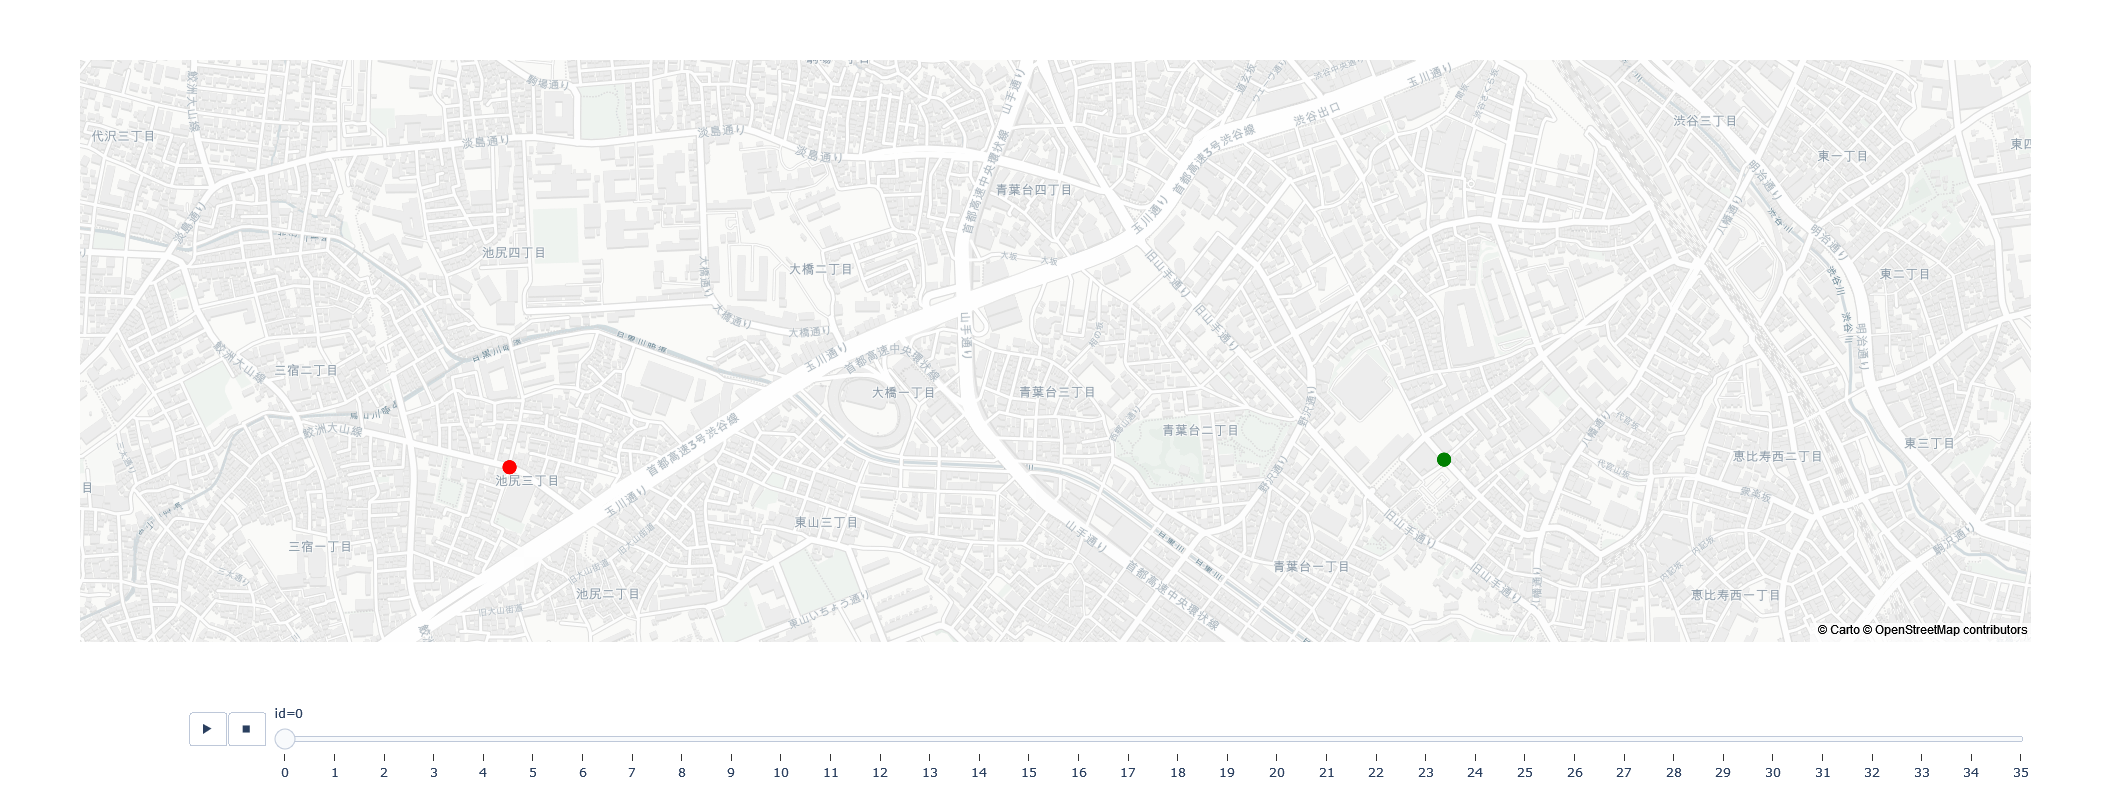

In [83]:
df_multiple = df_animation_multiple_path(G, [path_time, path_lenght], parallel=True)
plot_animation(df_multiple, start_node, end_node)

In [84]:
## get the node for each location
df["node"] = df[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
df = df.drop_duplicates("node", keep='first')
df.head()

,id,City,Street Address,y,x,node
0,0,2-3-6 Kyonancho,"2-3-6, Kyonancho",35.70,139.54,366813003
1,1,Adachi-ku,42-2 Senjuasahicho,35.75,139.80,1899999382
4,4,Akishima,562-1 Tananacho,35.71,139.36,554186575
5,5,Bunkyo-ku,3-1-3 Hongo,35.70,139.76,599542075
6,6,Bunkyo-ku,1-4-14 Koraku,35.70,139.75,1070541387


In [ ]:
## distance length function
def f(a,b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d = np.nan
    return d

distance_matrix = np.asarray([[f(a,b) for b in df["node"].tolist()] for a in df["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=df["node"].values, index=df["node"].values)
distance_matrix.head()

In [ ]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 0.3 if pd.isnull(x) else  #nan -> purple
                                               (0.7 if np.isinf(x) else   #inf -> orange
                                               (0 if x!=0 else 1) ))      # 0  -> white  
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

In [ ]:
# fillna with row average
distance_matrix = distance_matrix.T.fillna(distance_matrix.mean(axis=1)).T

# fillna with overall average
distance_matrix = distance_matrix.fillna(distance_matrix.mean().mean())

In [ ]:
## Business parameters
drivers = 1

lst_nodes = df["node"].tolist()
print("start:", start_node, "| tot locations to visit:", len(lst_nodes)-1, "| drivers:", drivers)

In [ ]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

In [ ]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index,to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

In [ ]:
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [ ]:
solution = model.SolveWithParameters(parameters)

index = model.Start(0)
print('Route for driver:')
route_idx, route_distance = [], 0
while not model.IsEnd(index):
    route_idx.append( manager.IndexToNode(index) ) 
    previous_index = index
    index = solution.Value( model.NextVar(index) )
    ### update distance
    try:
        route_distance += get_distance(previous_index, index)
    except:
        route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance: {round(route_distance/1000,2)} km')
print(f'Nodes visited: {len(route_idx)}')

In [ ]:
print("Route for driver (nodes):")
lst_route = [lst_nodes[i] for i in route_idx]
print(lst_route)

In [ ]:
# Get path between nodes
def get_path_between_nodes(lst_route):
    lst_paths = []
    for i in range(len(lst_route)):
        try:
            a, b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths = get_path_between_nodes(lst_route)
# Add paths on the map
for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map_, color="blue", weight=1)
map_

In [ ]:
## Business parameters
drivers = 3
driver_capacities = [20,20,20]
demands = [0] + [1]*(len(lst_nodes)-1)
max_distance = 1000

In [ ]:
# model - We need to create the manager, the model, and add the distance function
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

## add distance (cost)
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index,to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

In [ ]:
## add capacity (costraint)
def get_demand(from_index):
    return demands[from_index]

demand = model.RegisterUnaryTransitCallback(get_demand)
model.AddDimensionWithVehicleCapacity(demand, slack_max=0, vehicle_capacities=driver_capacities, fix_start_cumul_to_zero=True,name='Capacity')

## add limited distance (costraint)
name = 'Distance'
model.AddDimension(distance, slack_max=0, capacity=max_distance, fix_start_cumul_to_zero=True, name=name)
distance_dimension = model.GetDimensionOrDie(name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

## set strategy to minimize cost
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = model.SolveWithParameters(parameters)

In [ ]:
solution = model.SolveWithParameters(parameters)

dic_routes_idx, total_distance, total_load = {}, 0, 0
for driver in range(drivers):
    print(f'Route for driver {driver}:')
    index = model.Start(driver)
    route_idx, route_distance, route_load = [], 0, 0
    while not model.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route_idx.append( manager.IndexToNode(index) )
        previous_index = index
        index = solution.Value( model.NextVar(index) )
        ### update distance
        try:
            route_distance += get_distance(previous_index, index)
        except:
            route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=driver)
        ### update load
        route_load += demands[node_index]
        
    route_idx.append( manager.IndexToNode(index) )
    print(route_idx)
    dic_routes_idx[driver] = route_idx
    print(f'distance: {round(route_distance/1000,2)} km')
    print(f'load: {round(route_load,2)}', "\n")
    total_distance += route_distance
    total_load += route_load
    
print(f'Total distance: {round(total_distance/1000,2)} km')
print(f'Total load: {total_load}')

In [ ]:
# Convert from idx to nodes
dic_route = {}
for k,v in dic_routes_idx.items():
    print(f"Route for driver {k} (nodes):")
    dic_route[k] = [lst_nodes[i] for i in v]
    print(dic_route[k], "\n")

In [ ]:
# Get path between nodes
dic_paths = {k:get_path_between_nodes(v) for k,v in dic_route.items()}

# Add paths on the map
lst_colors = ["red","green","blue"]
for k,v in dic_paths.items():
    for path in v:
        ox.plot_route_folium(G, route=path, route_map=map_, color=lst_colors[k], weight=1)
map_

In [ ]:
df = pd.DataFrame()
for driver,lst_paths in dic_paths.items():
    tmp = df_animation_multiple_path(G, lst_paths, parallel=False)
    df = pd.concat([df,tmp], axis=0)

first_node, last_node = lst_paths[0][0], lst_paths[-1][-1]
plot_animation(df, first_node, last_node)